This article discusses alternative training strategies for variational quantum algorithms, specifically focusing on "post-variational strategies." These strategies address the challenges associated with the barren plateau problem in variational algorithms, which make gradient-based optimization difficult. In contrast to traditional variational methods that tune quantum circuit parameters, the proposed post-variational strategies optimize combinations of fixed quantum circuits using classical models, such as linear models or multilayer perceptrons. This approach shifts the tuning from the quantum to the classical realm, improving the trainability of the model at the expense of circuit expressibility.

The article demonstrates the application of post-variational quantum neural networks (QVNNs) for image classification, specifically identifying handwritten digits (twos and sixes). The results show improved training performance compared to variational algorithms. The dataset used consists of 8×8 pixel greyscale images, with 10% reserved for testing.

This approach offers a promising direction for overcoming the limitations of traditional variational methods by employing classical optimization techniques to enhance model trainability.


In [16]:
pip install pennylane

In [17]:
import pennylane as qml
from pennylane import numpy as np
import jax
from jax import numpy as jnp
import optax
from itertools import combinations
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import matplotlib.colors
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

# Load the digits dataset with features (X_digits) and labels (y_digits)
X_digits, y_digits = load_digits(return_X_y=True)

# Create a boolean mask to filter out only the samples where the label is 2 or 6
filter_mask = np.isin(y_digits, [2, 6])

# Apply the filter mask to the features and labels to keep only the selected digits
X_digits = X_digits[filter_mask]
y_digits = y_digits[filter_mask]

# Split the filtered dataset into training and testing sets with 10% of data reserved for testing
X_train, X_test, y_train, y_test = train_test_split(
    X_digits, y_digits, test_size=0.1, random_state=42
)

# Normalize the pixel values in the training and testing data
# Convert each image from a 1D array to an 8x8 2D array, normalize pixel values, and scale them
X_train = np.array([thing.reshape([8, 8]) / 16 * 2 * np.pi for thing in X_train])
X_test = np.array([thing.reshape([8, 8]) / 16 * 2 * np.pi for thing in X_test])

# Adjust the labels to be centered around 0 and scaled to be in the range -1 to 1
# The original labels (2 and 6) are mapped to -1 and 1 respectively
y_train = (y_train - 4) / 2
y_test = (y_test - 4) / 2

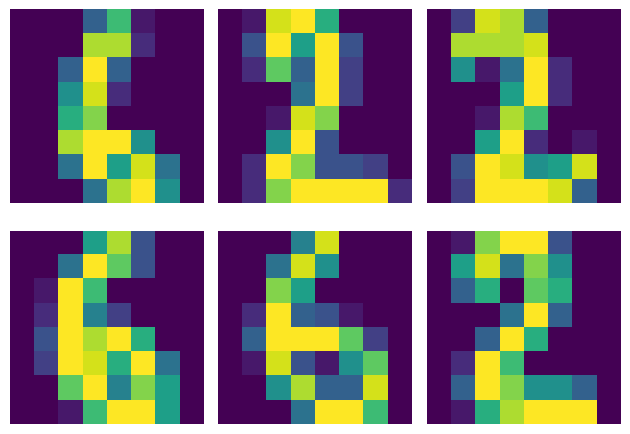

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=3, layout="constrained")
for i in range(2):
    for j in range(3):
      axes[i][j].matshow(X_train[2*(2*j+i)])
      axes[i][j].axis('off')
fig.subplots_adjust(hspace=0.0)
fig.tight_layout()
plt.show()

In [19]:
def feature_map(features):
    # Apply Hadamard gates to all qubits to create an equal superposition state
    for i in range(len(features[0])):
        qml.Hadamard(i)

    # Apply angle embeddings based on the feature values
    for i in range(len(features)):
        # For odd-indexed features, use Z-rotation in the angle embedding
        if i % 2:
            qml.AngleEmbedding(features=features[i], wires=range(8), rotation="Z")
        # For even-indexed features, use X-rotation in the angle embedding
        else:
            qml.AngleEmbedding(features=features[i], wires=range(8), rotation="X")

# Define the ansatz (quantum circuit ansatz) for parameterized quantum operations
def ansatz(params):
    # Apply RY rotations with the first set of parameters
    for i in range(8):
        qml.RY(params[i], wires=i)

    # Apply CNOT gates with adjacent qubits (cyclically connected) to create entanglement
    for i in range(8):
        qml.CNOT(wires=[(i - 1) % 8, (i) % 8])

    # Apply RY rotations with the second set of parameters
    for i in range(8):
        qml.RY(params[i + 8], wires=i)

    # Apply CNOT gates with qubits in reverse order (cyclically connected)
    # to create additional entanglement
    for i in range(8):
        qml.CNOT(wires=[(8 - 2 - i) % 8, (8 - i - 1) % 8])

In [20]:
dev = qml.device("default.qubit", wires=8)


@qml.qnode(dev)
def circuit(params, features):
    feature_map(features)
    ansatz(params)
    return qml.expval(qml.PauliZ(0))


def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias


def square_loss(labels, predictions):
    return np.mean((labels - qml.math.stack(predictions)) ** 2)


def accuracy(labels, predictions):
    acc = sum([np.sign(l) == np.sign(p) for l, p in zip(labels, predictions)])
    acc = acc / len(labels)
    return acc


def cost(params, X, Y):
    predictions = [variational_classifier(params["weights"], params["bias"], x) for x in X]
    return square_loss(Y, predictions)


def acc(params, X, Y):
    predictions = [variational_classifier(params["weights"], params["bias"], x) for x in X]
    return accuracy(Y, predictions)


np.random.seed(0)
weights = 0.01 * np.random.randn(16)
bias = jnp.array(0.0)
params = {"weights": weights, "bias": bias}
opt = optax.adam(0.05)
batch_size = 7
num_batch = X_train.shape[0] // batch_size
opt_state = opt.init(params)
X_batched = X_train.reshape([-1, batch_size, 8, 8])
y_batched = y_train.reshape([-1, batch_size])


@jax.jit
def update_step_jit(i, args):
    params, opt_state, data, targets, batch_no = args
    _data = data[batch_no % num_batch]
    _targets = targets[batch_no % num_batch]
    _, grads = jax.value_and_grad(cost)(params, _data, _targets)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return (params, opt_state, data, targets, batch_no + 1)


@jax.jit
def optimization_jit(params, data, targets):
    opt_state = opt.init(params)
    args = (params, opt_state, data, targets, 0)
    (params, opt_state, _, _, _) = jax.lax.fori_loop(0, 200, update_step_jit, args)
    return params


params = optimization_jit(params, X_batched, y_batched)
var_train_acc = acc(params, X_train, y_train)
var_test_acc = acc(params, X_test, y_test)

print("Training accuracy: ", var_train_acc)
print("Testing accuracy: ", var_test_acc)

Training accuracy:  0.7484472049689441
Testing accuracy:  0.6944444444444444


In [21]:
def local_pauli_group(qubits: int, locality: int):
    assert locality <= qubits, f"Locality must not exceed the number of qubits."
    return list(generate_paulis(0, 0, "", qubits, locality))

# This is a recursive generator function that constructs Pauli strings.
def generate_paulis(identities: int, paulis: int, output: str, qubits: int, locality: int):
    # Base case: if the output string's length matches the number of qubits, yield it.
    if len(output) == qubits:
        yield output
    else:
        # Recursive case: add an "I" (identity) to the output string.
        yield from generate_paulis(identities + 1, paulis, output + "I", qubits, locality)

        # If the number of Pauli operators used is less than the locality, add "X", "Y", or "Z"
        # systematically builds all possible Pauli strings that conform to the specified locality.
        if paulis < locality:
            yield from generate_paulis(identities, paulis + 1, output + "X", qubits, locality)
            yield from generate_paulis(identities, paulis + 1, output + "Y", qubits, locality)
            yield from generate_paulis(identities, paulis + 1, output + "Z", qubits, locality)

1-local: 
Training loss:  0.5567337925309377
Testing loss:  0.5602685345579601
Training accuracy:  0.782608695652174
Testing accuracy:  0.7777777777777778

2-local: 
Training loss:  0.48440244587712483
Testing loss:  0.555829752450422
Training accuracy:  0.8416149068322981
Testing accuracy:  0.7777777777777778

3-local: 
Training loss:  0.32810235311728486
Testing loss:  0.5938181338672985
Training accuracy:  0.9347826086956522
Testing accuracy:  0.75



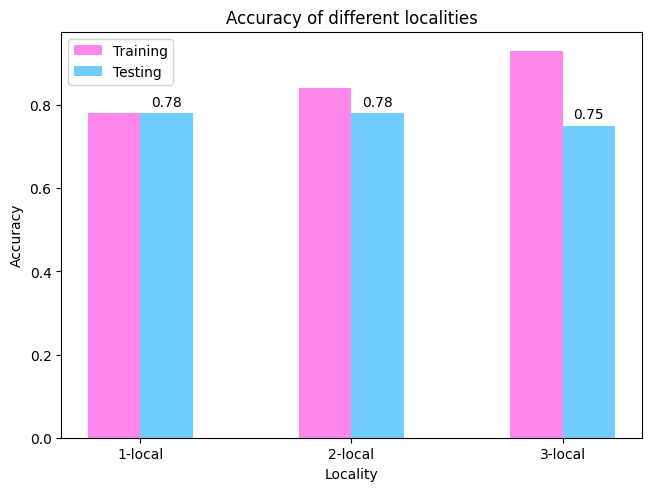

In [28]:
# Initialize lists to store training and testing accuracies for different localities.
train_accuracies_O = []
test_accuracies_O = []

for locality in range(1, 4):
    print(str(locality) + "-local: ")

    # Define a quantum device with 8 qubits using the default simulator.
    dev = qml.device("default.qubit", wires=8)

    # Define a quantum node (qnode) with the quantum circuit that will be executed on the device.
    @qml.qnode(dev)
    def circuit(features):
        # Generate all possible Pauli strings for the given locality.
        measurements = local_pauli_group(8, locality)

        # Apply the feature map to encode classical data into quantum states.
        feature_map(features)

        # Measure the expectation values of the generated Pauli operators.
        return [qml.expval(qml.pauli.string_to_pauli_word(measurement)) for measurement in measurements]

    # Vectorize the quantum circuit function to apply it to multiple data points in parallel.
    vcircuit = jax.vmap(circuit)

    # Transform the training and testing datasets by applying the quantum circuit.
    new_X_train = np.asarray(vcircuit(jnp.array(X_train))).T
    new_X_test = np.asarray(vcircuit(jnp.array(X_test))).T

    # Train a Multilayer Perceptron (MLP) classifier on the transformed training data.
    clf = MLPClassifier(early_stopping=True).fit(new_X_train, y_train)

    # Print the log loss for the training data.
    print("Training loss: ", log_loss(y_train, clf.predict_proba(new_X_train)))

    # Print the log loss for the testing data.
    print("Testing loss: ", log_loss(y_test, clf.predict_proba(new_X_test)))

    # Calculate and store the training accuracy.
    acc = clf.score(new_X_train, y_train)
    train_accuracies_O.append(acc)
    print("Training accuracy: ", acc)

    # Calculate and store the testing accuracy.
    acc = clf.score(new_X_test, y_test)
    test_accuracies_O.append(acc)
    print("Testing accuracy: ", acc)
    print()

locality = ("1-local", "2-local", "3-local")
train_accuracies_O = [round(value, 2) for value in train_accuracies_O]
test_accuracies_O = [round(value, 2) for value in test_accuracies_O]
x = np.arange(3)
width = 0.25

# Create a bar plot to visualize the training and testing accuracies.
fig, ax = plt.subplots(layout="constrained")
# Training accuracy bars:
rects = ax.bar(x, train_accuracies_O, width, label="Training", color="#FF87EB")
# Testing accuracy bars:
rects = ax.bar(x + width, test_accuracies_O, width, label="Testing", color="#70CEFF")
ax.bar_label(rects, padding=3)
ax.set_xlabel("Locality")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy of different localities")
ax.set_xticks(x + width / 2, locality)
ax.legend(loc="upper left")
plt.show()

In [29]:
def deriv_params(thetas: int, order: int):
    # This function generates parameter shift values for calculating derivatives
    # of a quantum circuit.
    # 'thetas' is the number of parameters in the circuit.
    # 'order' determines the order of the derivative to calculate (1st order, 2nd order, etc.).

    def generate_shifts(thetas: int, order: int):
        # Generate all possible combinations of parameters to shift for the given order.
        shift_pos = list(combinations(np.arange(thetas), order))

        # Initialize a 3D array to hold the shift values.
        # Shape: (number of combinations, 2^order, thetas)
        params = np.zeros((len(shift_pos), 2 ** order, thetas))

        # Iterate over each combination of parameter shifts.
        for i in range(len(shift_pos)):
            # Iterate over each possible binary shift pattern for the given order.
            for j in range(2 ** order):
                # Convert the index j to a binary string of length 'order'.
                for k, l in enumerate(f"{j:0{order}b}"):
                    # For each bit in the binary string:
                    if int(l) > 0:
                        # If the bit is 1, increment the corresponding parameter.
                        params[i][j][shift_pos[i][k]] += 1
                    else:
                        # If the bit is 0, decrement the corresponding parameter.
                        params[i][j][shift_pos[i][k]] -= 1

        # Reshape the parameters array to collapse the first two dimensions.
        params = np.reshape(params, (-1, thetas))
        return params

    # Start with a list containing a zero-shift array for all parameters.
    param_list = [np.zeros((1, thetas))]

    # Append the generated shift values for each order from 1 to the given order.
    for i in range(1, order + 1):
        param_list.append(generate_shifts(thetas, i))

    # Concatenate all the shift arrays along the first axis to create the final parameter array.
    params = np.concatenate(param_list, axis=0)

    # Scale the shift values by π/2.
    params *= np.pi / 2

    return params

In [30]:
n_wires = 8
dev = qml.device("default.qubit", wires=n_wires)

@jax.jit
@qml.qnode(dev, interface="jax")
def circuit(features, params, n_wires=8):
    feature_map(features)
    ansatz(params)
    return qml.expval(qml.PauliZ(0))

Order number: 1
Training loss:  0.7424751782920129
Testing loss:  0.7582862719522725
Training accuracy:  0.4968944099378882
Testing accuracy:  0.4722222222222222

Order number: 2
Training loss:  0.6158928658662948
Testing loss:  0.6033058232354203
Training accuracy:  0.7329192546583851
Testing accuracy:  0.6666666666666666

Order number: 3
Training loss:  0.5813864112092096
Testing loss:  0.5992989465404857
Training accuracy:  0.7049689440993789
Testing accuracy:  0.6944444444444444



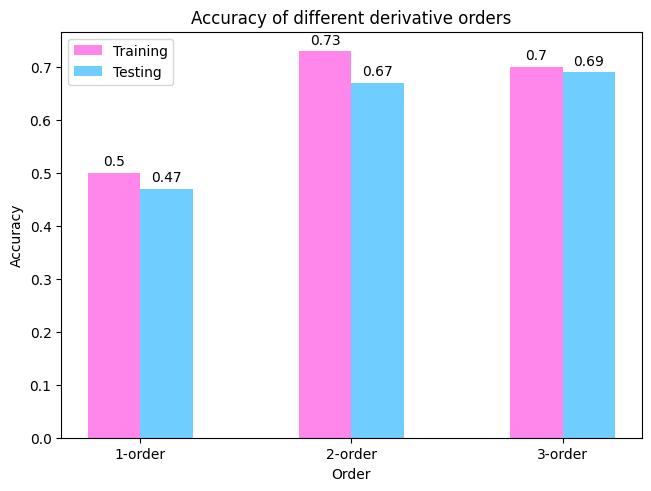

In [31]:
# Initialize lists to store training and testing accuracies for different derivative orders.
train_accuracies_AE = []
test_accuracies_AE = []

# Loop through different derivative orders (1st order, 2nd order, 3rd order).
for order in range(1, 4):
    print("Order number: " + str(order))

    # Generate the parameter shifts required for the given derivative order.
    to_measure = deriv_params(16, order)

    # Transform the training dataset by applying the quantum circuit with the
    # generated parameter shifts.
    new_X_train = []
    for thing in X_train:
        result = circuit(thing, to_measure.T)
        new_X_train.append(result)

    # Transform the testing dataset similarly.
    new_X_test = []
    for thing in X_test:
        result = circuit(thing, to_measure.T)
        new_X_test.append(result)

    # Train a Multilayer Perceptron (MLP) classifier on the transformed training data.
    clf = MLPClassifier(early_stopping=True).fit(new_X_train, y_train)

    # Print the log loss for the training data.
    print("Training loss: ", log_loss(y_train, clf.predict_proba(new_X_train)))

    # Print the log loss for the testing data.
    print("Testing loss: ", log_loss(y_test, clf.predict_proba(new_X_test)))

    # Calculate and store the training accuracy.
    acc = clf.score(new_X_train, y_train)
    train_accuracies_AE.append(acc)
    print("Training accuracy: ", acc)

    # Calculate and store the testing accuracy.
    acc = clf.score(new_X_test, y_test)
    test_accuracies_AE.append(acc)
    print("Testing accuracy: ", acc)
    print()

locality = ("1-order", "2-order", "3-order")
train_accuracies_AE = [round(value, 2) for value in train_accuracies_AE]
test_accuracies_AE = [round(value, 2) for value in test_accuracies_AE]
x = np.arange(3)
width = 0.25
fig, ax = plt.subplots(layout="constrained")
rects = ax.bar(x, train_accuracies_AE, width, label="Training", color="#FF87EB")
ax.bar_label(rects, padding=3)
rects = ax.bar(x + width, test_accuracies_AE, width, label="Testing", color="#70CEFF")
ax.bar_label(rects, padding=3)
ax.set_xlabel("Order")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy of different derivative orders")
ax.set_xticks(x + width / 2, locality)
ax.legend(loc="upper left")
plt.show()

In [32]:
# Initialize matrices to store training and testing accuracies for different
# combinations of locality and order.
train_accuracies = np.zeros([4, 4])
test_accuracies = np.zeros([4, 4])

# Loop through different derivative orders (1st to 3rd) and localities (1-local to 3-local).
for order in range(1, 4):
    for locality in range(1, 4):
        # Skip invalid combinations where locality + order exceeds 3 or equals 0.
        if locality + order > 3 or locality + order == 0:
            continue
        print("Locality: " + str(locality) + " Order: " + str(order))

        # Define a quantum device with 8 qubits using the default simulator.
        dev = qml.device("default.qubit", wires=8)

        # Generate the parameter shifts required for the given derivative order and transpose them.
        params = deriv_params(16, order).T

        # Define a quantum node (qnode) with the quantum circuit that will be executed on the device.
        @qml.qnode(dev)
        def circuit(features, params):
            # Generate the Pauli group for the given locality.
            measurements = local_pauli_group(8, locality)
            feature_map(features)
            ansatz(params)
            # Measure the expectation values of the generated Pauli operators.
            return [qml.expval(qml.pauli.string_to_pauli_word(measurement)) for measurement in measurements]

        # Vectorize the quantum circuit function to apply it to multiple data points in parallel.
        vcircuit = jax.vmap(circuit)

        # Transform the training dataset by applying the quantum circuit with the
        # generated parameter shifts.
        new_X_train = np.asarray(
            vcircuit(jnp.array(X_train), jnp.array([params for i in range(len(X_train))]))
        )
        # Reorder the axes and reshape the transformed data for input into the classifier.
        new_X_train = np.moveaxis(new_X_train, 0, -1).reshape(
            -1, len(local_pauli_group(8, locality)) * len(deriv_params(16, order))
        )

        # Transform the testing dataset similarly.
        new_X_test = np.asarray(
            vcircuit(jnp.array(X_test), jnp.array([params for i in range(len(X_test))]))
        )
        # Reorder the axes and reshape the transformed data for input into the classifier.
        new_X_test = np.moveaxis(new_X_test, 0, -1).reshape(
            -1, len(local_pauli_group(8, locality)) * len(deriv_params(16, order))
        )

        # Train a Multilayer Perceptron (MLP) classifier on the transformed training data.
        clf = MLPClassifier(early_stopping=True).fit(new_X_train, y_train)

        # Calculate and store the training and testing accuracies.
        train_accuracies[order][locality] = clf.score(new_X_train, y_train)
        test_accuracies[order][locality] = clf.score(new_X_test, y_test)

        print("Training loss: ", log_loss(y_train, clf.predict_proba(new_X_train)))
        print("Testing loss: ", log_loss(y_test, clf.predict_proba(new_X_test)))
        acc = clf.score(new_X_train, y_train)
        train_accuracies[locality][order] = acc
        print("Training accuracy: ", acc)
        acc = clf.score(new_X_test, y_test)
        test_accuracies[locality][order] = acc
        print("Testing accuracy: ", acc)
        print()

Locality: 1 Order: 1
Training loss:  0.28579913496353254
Testing loss:  0.5101661086248751
Training accuracy:  0.906832298136646
Testing accuracy:  0.8055555555555556

Locality: 2 Order: 1
Training loss:  0.13502707804878447
Testing loss:  0.6608379240942234
Training accuracy:  0.9720496894409938
Testing accuracy:  0.8055555555555556

Locality: 1 Order: 2
Training loss:  0.3649124614163017
Testing loss:  0.5555798027517465
Training accuracy:  0.84472049689441
Testing accuracy:  0.7222222222222222



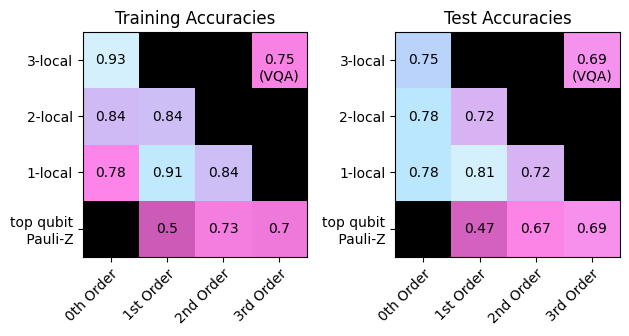

In [33]:
for locality in range(1, 4):
    train_accuracies[locality][0] = train_accuracies_O[locality - 1]
    test_accuracies[locality][0] = test_accuracies_O[locality - 1]
for order in range(1, 4):
    train_accuracies[0][order] = train_accuracies_AE[order - 1]
    test_accuracies[0][order] = test_accuracies_AE[order - 1]

train_accuracies[3][3] = var_train_acc
test_accuracies[3][3] = var_test_acc

cvals = [0, 0.5, 0.85, 0.95, 1]
colors = ["black", "#C756B2", "#FF87EB", "#ACE3FF", "#D5F0FD"]
norm = plt.Normalize(min(cvals), max(cvals))
tuples = list(zip(map(norm, cvals), colors))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)


locality = ["top qubit\n Pauli-Z", "1-local", "2-local", "3-local"]
order = ["0th Order", "1st Order", "2nd Order", "3rd Order"]

fig, axes = plt.subplots(nrows=1, ncols=2, layout="constrained")
im = axes[0].imshow(train_accuracies, cmap=cmap, origin="lower")

axes[0].set_yticks(np.arange(len(locality)), labels=locality)
axes[0].set_xticks(np.arange(len(order)), labels=order)
plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(len(locality)):
    for j in range(len(order)):
        text = axes[0].text(
            j, i, np.round(train_accuracies[i, j], 2), ha="center", va="center", color="black"
        )
axes[0].text(3, 3, '\n\n(VQA)', ha="center", va="center", color="black")

axes[0].set_title("Training Accuracies")

locality = ["top qubit\n Pauli-Z", "1-local", "2-local", "3-local"]
order = ["0th Order", "1st Order", "2nd Order", "3rd Order"]

im = axes[1].imshow(test_accuracies, cmap=cmap, origin="lower")

axes[1].set_yticks(np.arange(len(locality)), labels=locality)
axes[1].set_xticks(np.arange(len(order)), labels=order)
plt.setp(axes[1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(len(locality)):
    for j in range(len(order)):
        text = axes[1].text(
            j, i, np.round(test_accuracies[i, j], 2), ha="center", va="center", color="black"
        )
axes[1].text(3, 3, '\n\n(VQA)', ha="center", va="center", color="black")

axes[1].set_title("Test Accuracies")
fig.tight_layout()
plt.show()